In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import dash
import plotly.graph_objects as go
from dash import dcc, html
import collections
from pptx import Presentation

In [2]:
df_hosp = pd.read_excel('HospitalDatabase.xlsx',sheet_name = None)
pats=df_hosp['Patients']
ed_visits=df_hosp['EDVisits']
amb_visits=df_hosp['AmbulatoryVisits']
re_adm=df_hosp['ReAdmissionRegistry']
discharges=df_hosp['Discharges']
providers=df_hosp['Providers']
ed_unique=df_hosp['EDUnique']

# 1.Create a stacked bar chart for patients with age and gender using bins for age.

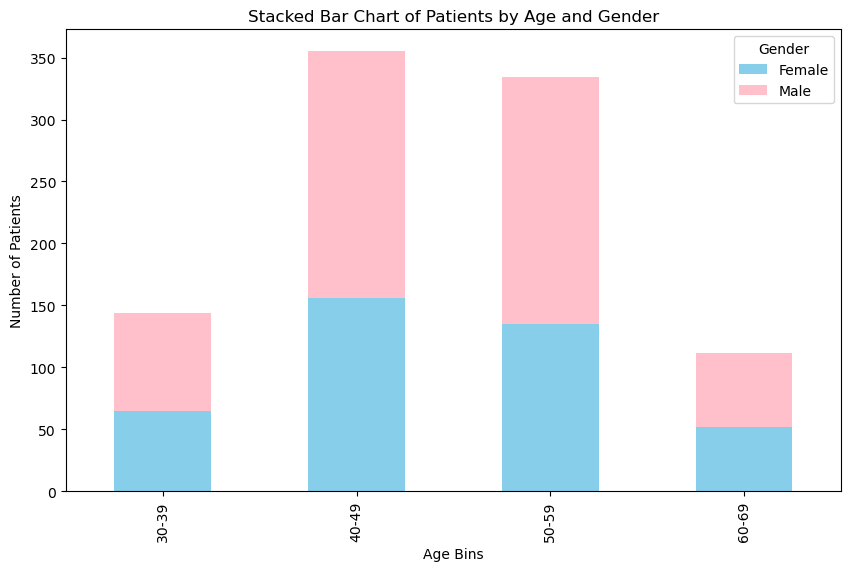

In [3]:
# Calculate age from date of birth
current_year = datetime.now().year
pats['Age'] = current_year - pd.DatetimeIndex(pats['DateOfBirth']).year

# Create age bins
age_bins = [10 * i for i in range(3, 8)]  # Create bins: 30, 40, ..., 70
pats['AgeBin'] = pd.cut(pats['Age'], bins=age_bins, labels=[f'{i}-{i+9}' for i in age_bins[:-1]])

# Group data by age bins and gender
grouped_data = pats.groupby(['AgeBin', 'Gender']).size().unstack()

# Plot a stacked bar chart
colors = ['skyblue', 'pink']
ax = grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
ax.set_xlabel('Age Bins')
ax.set_ylabel('Number of Patients')
ax.set_title('Stacked Bar Chart of Patients by Age and Gender')
ax.legend(title='Gender', loc='upper right')

plt.show()



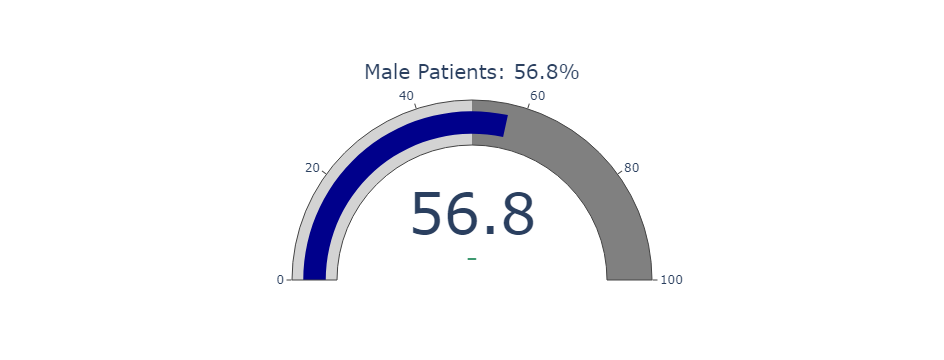

In [42]:
gender_counts = pats['Gender'].value_counts()

# Total number of patients
total_patients = gender_counts.sum()

# Calculate the percentage of male patients
male_percentage = gender_counts['Male'] / total_patients * 100

# Format the percentage as a string with one decimal place
formatted_male_percentage = "{:.1f}%".format(male_percentage)

# Create a gauge-like chart using Plotly
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number+gauge+delta",
    value=male_percentage,
    title={"text": "Male Patients"},
    gauge={
        "axis": {"range": [0, 100]},
        "bar": {"color": "darkblue"},
        "steps": [
            {"range": [0, 50], "color": "lightgray"},
            {"range": [50, 100], "color": "gray"}
        ],
    }
))

# formatted percentage as the title of the gauge
fig.update_traces(title_text="Male Patients: "+ formatted_male_percentage)

fig.show()


# 2.Which reason for visit are discharged the most.

In [6]:
# Filter EDDisposition with only "discharge"
discharged_visits = ed_visits[ed_visits['EDDisposition'] == 'Discharged']

# Group data by ReasonForVisit and calculate the count
reason_counts = discharged_visits['ReasonForVisit'].value_counts()

most_common_reason = reason_counts.idxmax()

print(f"The most common Discharged reason for Visit is: {most_common_reason}")


The most common Discharged reason for Visit is: Fever


# 3.Using iloc display full details of the longest stayed patient.

In [7]:
# Convert columns to datetime data types
ed_visits['EDDischargeTime'] = pd.to_datetime(ed_visits['EDDischargeTime'])
ed_visits['VisitDate'] = pd.to_datetime(ed_visits['VisitDate'])

ed_visits['StayDuration'] = ed_visits['EDDischargeTime'] - ed_visits['VisitDate']

index_longest_stay = ed_visits['StayDuration'].idxmax()

# Use .iloc
longest_stay_details = ed_visits.iloc[index_longest_stay]

# Extract hours, minutes, and seconds
stay_duration = longest_stay_details['StayDuration']
hours = stay_duration.seconds // 3600
minutes = (stay_duration.seconds % 3600) // 60
seconds = stay_duration.seconds % 60

print("Details of the longest stay:")
print(f"Stay Duration: {hours} hours, {minutes} minutes, {seconds} seconds")
print("Complete Details:")
print(longest_stay_details.drop('StayDuration'))

Details of the longest stay:
Stay Duration: 23 hours, 59 minutes, 43 seconds
Complete Details:
EDVisitID                                1143
PatientID                                 889
VisitDate          2020-01-14 21:28:14.588000
EDDischargeTime    2020-01-15 21:27:58.579000
Acuity                                      2
ReasonForVisit                      Pneumonia
EDDisposition                        Admitted
Name: 486, dtype: object


# 4.Plot ExpectedLOS based on Primary Diagnosis

C:\Users\Amitha\AppData\Local\Temp\ipykernel_36960\4115045083.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



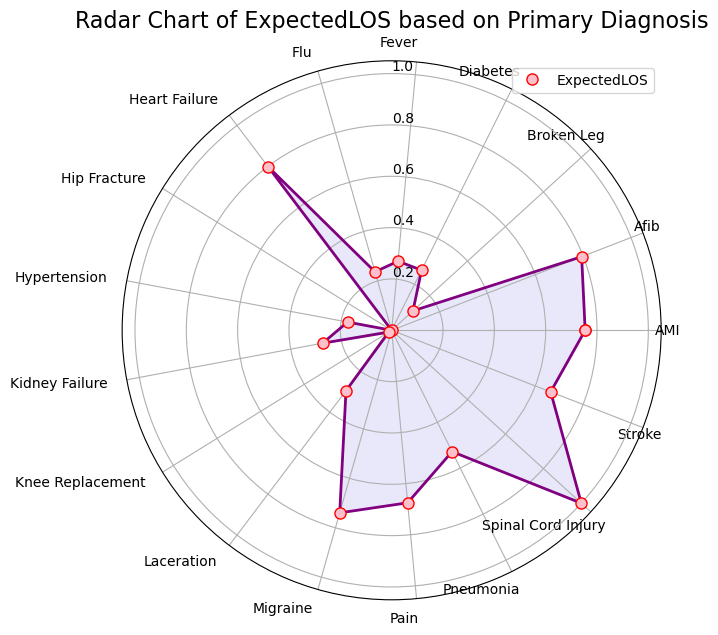

In [40]:
# Group data by Primary Diagnosis and calculate mean ExpectedLOS
diagnosis_los = re_adm.groupby('PrimaryDiagnosis')['ExpectedLOS'].mean()

diagnoses = diagnosis_los.index.tolist()

normalized_los = (diagnosis_los - diagnosis_los.min()) / (diagnosis_los.max() - diagnosis_los.min())

normalized_los = normalized_los.append(pd.Series([normalized_los.iloc[0]], index=[normalized_los.index[-1]]))

# Create angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(diagnoses) + 1)

# Plot the radar chart
plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
ax.fill(angles, normalized_los, color='lavender', alpha=0.9)
ax.plot(angles, normalized_los, color='purple', linewidth=2)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(diagnoses, ha='right')

ax.set_rlabel_position(90)
ax.set_title('Radar Chart of ExpectedLOS based on Primary Diagnosis', fontsize=16)
ax.plot(angles, normalized_los, 'o', markersize=8, color='red', markerfacecolor='pink', label='ExpectedLOS')
ax.legend(loc='upper right')

plt.show()

# 5: Create a 3d barplot chart by filtering Service= ["ICU", "Neurology", "General Medicine"] and find the occurence of only ExpectedLOS=[10,5,7,9] in them.

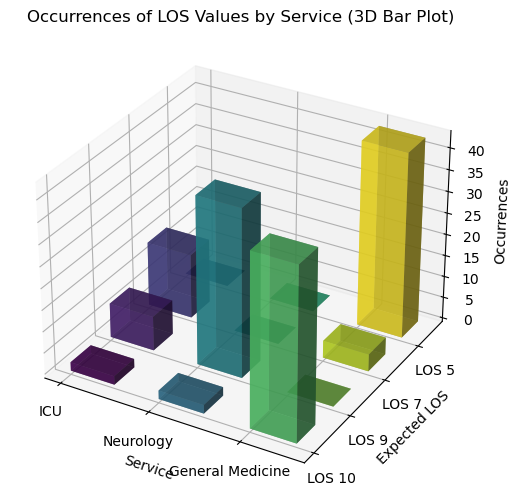

In [9]:
# Rounding up LOS
re_adm['expected_los'] = np.ceil(re_adm['ExpectedLOS'])

# Filter services
filter_service = ["ICU", "Neurology", "General Medicine"]
select_service = re_adm[re_adm["Service"].isin(filter_service)]
select_LOS = [10, 9, 7, 5]

# Count occurrences of specified LOS
service_counts = {}
for service in filter_service:
    service_data = select_service[select_service["Service"] == service]
    los_sum_counts = [service_data["expected_los"].isin([los]).sum() for los in select_LOS]
    service_counts[service] = los_sum_counts

service_names = list(service_counts.keys())
occurrences = np.array(list(service_counts.values())).T

# Create a 3D bar plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

xpos, ypos = np.meshgrid(np.arange(len(service_names)), np.arange(len(select_LOS)), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = dy = 0.5
dz = occurrences.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, len(service_names) * len(select_LOS)))

for i in range(len(service_names) * len(select_LOS)):
    ax.bar3d(xpos[i], ypos[i], zpos[i], dx, dy, dz[i], shade=True, color=colors[i], alpha=0.7)

ax.set_xlabel('Service')
ax.set_ylabel('Expected LOS')
ax.set_zlabel('Occurrences')
ax.set_title('Occurrences of LOS Values by Service (3D Bar Plot)')
ax.set_xticks(np.arange(len(service_names)))
ax.set_xticklabels(service_names)
ax.set_yticks(np.arange(len(select_LOS)))
ax.set_yticklabels([f'LOS {los}' for los in select_LOS])

plt.show()



# 6: Using class function merge sheets to lookup provider name and provider speciality with the given patient ID

In [10]:
class HospitalData:
    def __init__(self, df_hosp):
        self.df_hosp = df_hosp

    def get_patient_info(self, patient_id):
        patients = self.df_hosp['Patients']
        ambulatory_visits = self.df_hosp['AmbulatoryVisits']
        providers = self.df_hosp['Providers'] 
        
        merged_data = pd.merge(patients, ambulatory_visits,
                               left_on='PatientID', right_on='PatientMRN', how='inner')
        
        merged_data = pd.merge(merged_data, providers,
                               left_on='ProviderID', right_on='ProviderID', how='left')
        
        patient_data = merged_data[merged_data['PatientID'] == patient_id]
        
        if patient_data.empty:
            print("Patient ID not found.")
        else:
            full_name = f"{patient_data['FirstName'].iloc[0]} {patient_data['LastName'].iloc[0]}"
            provider_name = patient_data['ProviderName'].iloc[0]
            provider_speciality = patient_data['ProviderSpecialty'].iloc[0]
            
            print(f"Full Name: {full_name}")
            print(f"Provider Name: {provider_name}")
            print(f"Provider Speciality: {provider_speciality}")

# Create a HospitalData object
hospital = HospitalData(df_hosp)

patient_id_input = int(input("Enter Patient ID: "))

hospital.get_patient_info(patient_id_input)


Enter Patient ID:  55


Full Name: Chandler  Pow
Provider Name: Trent Tye
Provider Speciality: PrimaryCare


# 7: Add a drop down menu to your Primary Diagnosis and when selected display its averageLOS and averageMOrtality

In [11]:
# Create a empty Dictionary
cached_results = {}

def calculate_metrics(service_data):
    if not service_data.empty:
        avg_los = service_data['expected_los'].mean()
        mean_mortality = service_data['ExpectedMortality'].mean()
        return avg_los, mean_mortality
    return None, None

def on_dropdown_change(change):
    with output:
        output.clear_output()
        selected_service = change.new
        
        if selected_service in cached_results:
            avg_los, mean_mortality = cached_results[selected_service]
        else:
            service_data = re_adm[re_adm['PrimaryDiagnosis'] == selected_service]
            avg_los, mean_mortality = calculate_metrics(service_data)
            cached_results[selected_service] = avg_los, mean_mortality
        
        if avg_los is not None and mean_mortality is not None:
            print(f"Selected Primary Service: {selected_service}")
            print(f"Average LOS: {avg_los:.2f}")
            print(f"Mean Expected Mortality: {mean_mortality:.2f}")
        else:
            print(f"No data available for {selected_service}")

# Create a dropdown widget with primary services
primary_services = re_adm['PrimaryDiagnosis'].unique()
service_dropdown = widgets.Dropdown(options=primary_services, description='Primary Service:')
output = widgets.Output()

service_dropdown.observe(on_dropdown_change, names='value')

display(service_dropdown, output)


Dropdown(description='Primary Service:', options=('Kidney Failure', 'Flu', 'Heart Failure', 'Pneumonia', 'AMI'…

Output()

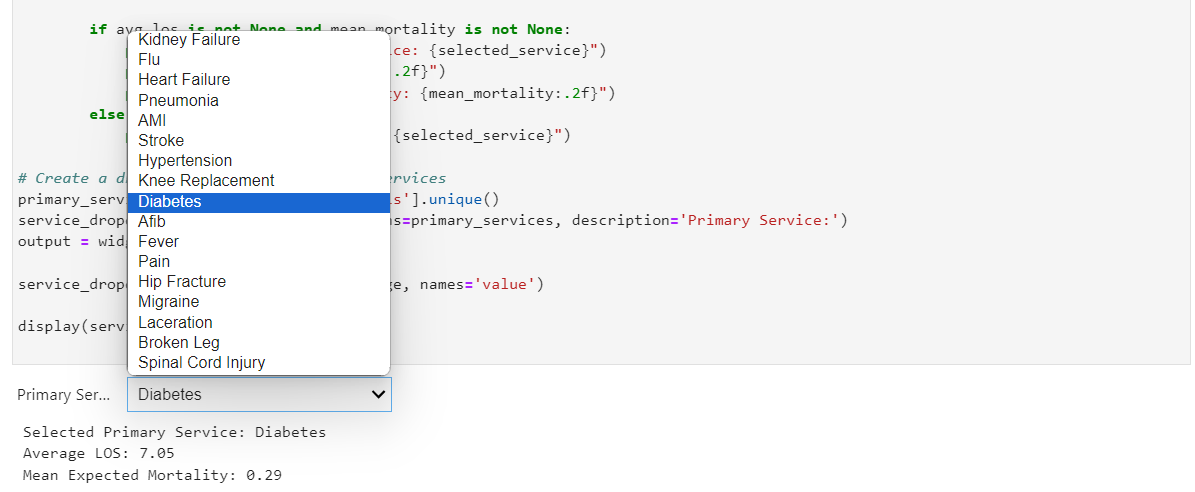

# 8:Use sankey Chart to show the flow of patient from Primary Diagnosis to Discharge Disposition"

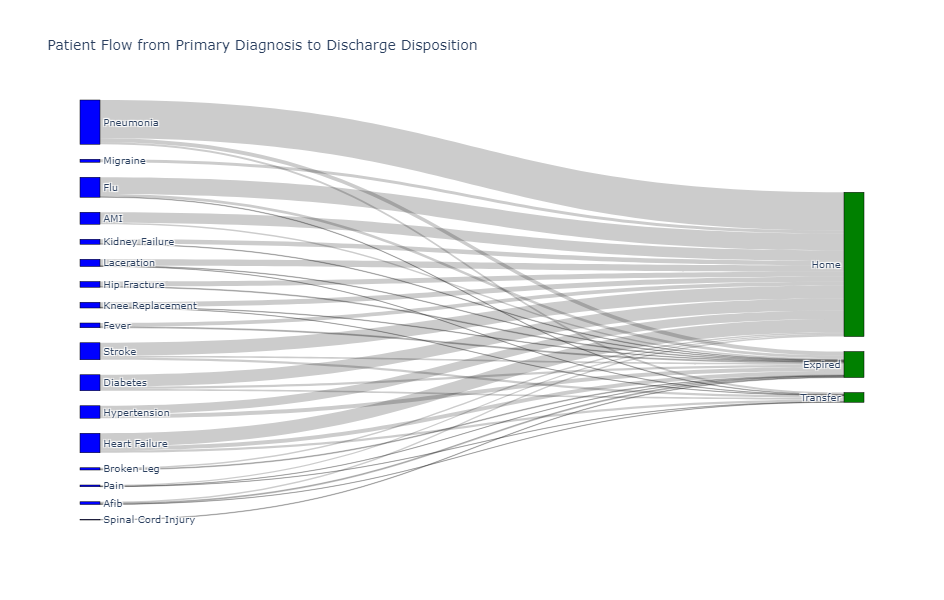

In [12]:
# Calculate counts for each combination
count_data = re_adm.groupby(['PrimaryDiagnosis', 'DischargeDisposition']).count().reset_index()

# Create a Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=count_data['PrimaryDiagnosis'].unique().tolist() + count_data['DischargeDisposition'].unique().tolist(),
        color=["blue"] * len(count_data['PrimaryDiagnosis'].unique().tolist()) + ["green"] * len(count_data['DischargeDisposition'].unique().tolist())
    ),
    link=dict(
        source=count_data['PrimaryDiagnosis'].apply(lambda x: count_data['PrimaryDiagnosis'].unique().tolist().index(x)),
        target=count_data['DischargeDisposition'].apply(lambda x: len(count_data['PrimaryDiagnosis'].unique().tolist()) + count_data['DischargeDisposition'].unique().tolist().index(x)),
        value=count_data['PatientID']
    )
))

fig.update_layout(title_text="Patient Flow from Primary Diagnosis to Discharge Disposition",
                  font_size=10, width=800,height=600 )
fig.show()


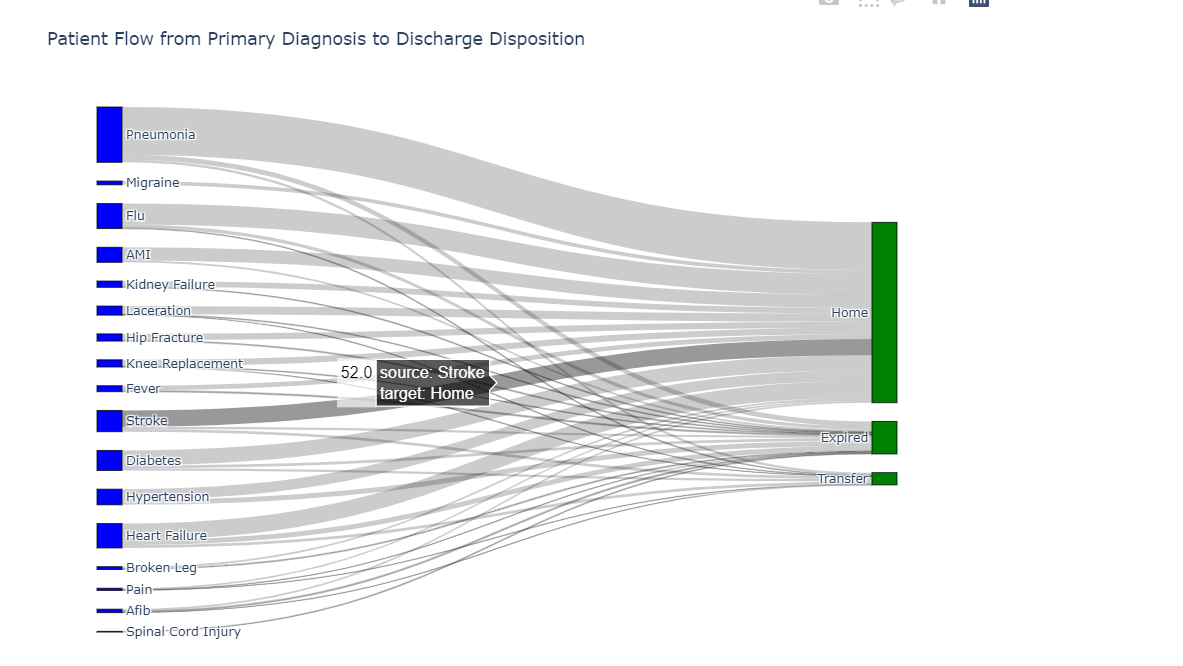

# 8.Check for number of readmission patients and show their distribution among acuity.

In [13]:
repeated_patientids = ed_visits[ed_visits.duplicated('PatientID', keep=False)]['PatientID'].unique()

# Filter repeated patients and count readmissions by acuity
readmitted_acuity_count = {}

for patient_id in repeated_patientids:
    patient_data = ed_visits[ed_visits['PatientID'] == patient_id]
    if patient_data['EDDisposition'].nunique() > 1:
        acuity = patient_data['Acuity'].iloc[0]  # Assuming 'Acuity' is the same for readmissions
        if acuity not in readmitted_acuity_count:
            readmitted_acuity_count[acuity] = 1
        else:
            readmitted_acuity_count[acuity] += 1

print("Readmitted patients by acuity:")
for acuity, count in readmitted_acuity_count.items():
    print(f"Acuity {acuity}: {count} patients")


Readmitted patients by acuity:
Acuity 1: 7 patients
Acuity 2: 21 patients
Acuity 3: 19 patients
Acuity 4: 24 patients
Acuity 5: 44 patients


# 9.Plot 3d Bubble chart to display expired patient count across race gender and age. Give a parameter to select the primary diagnosis and also gender interactive.

In [14]:
merged_data = pd.merge(re_adm, pats, on='PatientID')

merged_data['DischargeDate'] = pd.to_datetime(merged_data['DischargeDate'])
merged_data['DateOfBirth'] = pd.to_datetime(merged_data['DateOfBirth'])
merged_data['age'] = (merged_data['DischargeDate'] - merged_data['DateOfBirth']).dt.days // 365

# Mapping Gender and Race
merged_data['Gender'] = merged_data['Gender'].replace({1: 'Male', 2: 'Female'})
merged_data['Race'] = merged_data['Race'].replace({1: 'White', 2: 'Black/African-American'})

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id='diagnosis-dropdown',
        options=[
            {'label': diagnosis, 'value': diagnosis}
            for diagnosis in merged_data['PrimaryDiagnosis'].unique()
        ],
        value=merged_data['PrimaryDiagnosis'].unique()[0],  # Default value
        multi=False,
        placeholder="Select a Primary Diagnosis"
    ),
    dcc.Graph(id='bubble-chart')
])

# Callback to update the 3D bubble chart
@app.callback(
    dash.dependencies.Output('bubble-chart', 'figure'),
    [
        dash.dependencies.Input('diagnosis-dropdown', 'value')
    ]
)
def update_bubble_chart(selected_diagnosis):
    filtered_data = merged_data[
        (merged_data['PrimaryDiagnosis'] == selected_diagnosis) & 
        (merged_data['DischargeDisposition'] == 'Expired')  # Filter for DischargeDisposition
    ]
    fig = px.scatter_3d(
        filtered_data,
        x='PrimaryDiagnosis',
        y='age',
        z='Race',
        size='age',       
        color='Gender',
        color_discrete_map={'Male': 'blue', 'Female': 'pink'}, 
        title=f"3D Bubble Chart for Primary Diagnosis: {selected_diagnosis} (Expired Discharge)"
    )
    fig.update_traces(marker=dict(line=dict(width=2, color='white'))) 
    fig.update_layout(
        scene=dict(zaxis_title='Race'),
        width=1000,
        height=700,
        margin=dict(l=0, r=0, b=0, t=0)  # Adjust these margin 
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


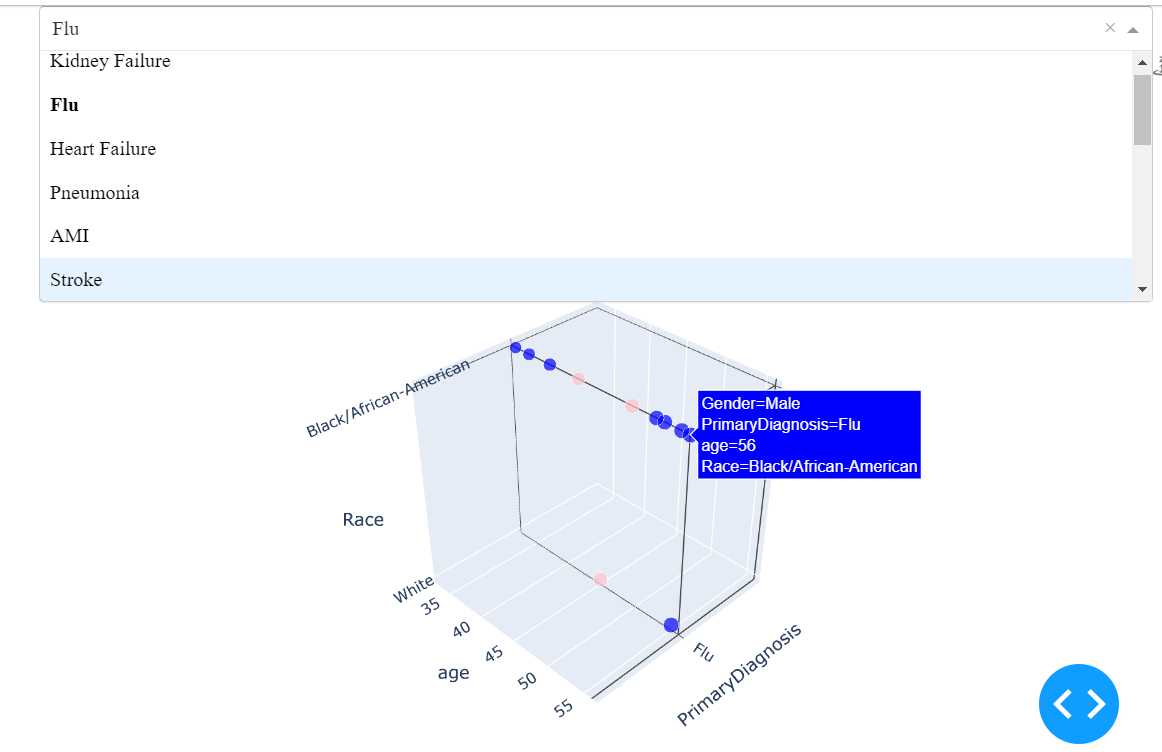

# 10.Plot a reverse bar graph to show patient count in each departmentID

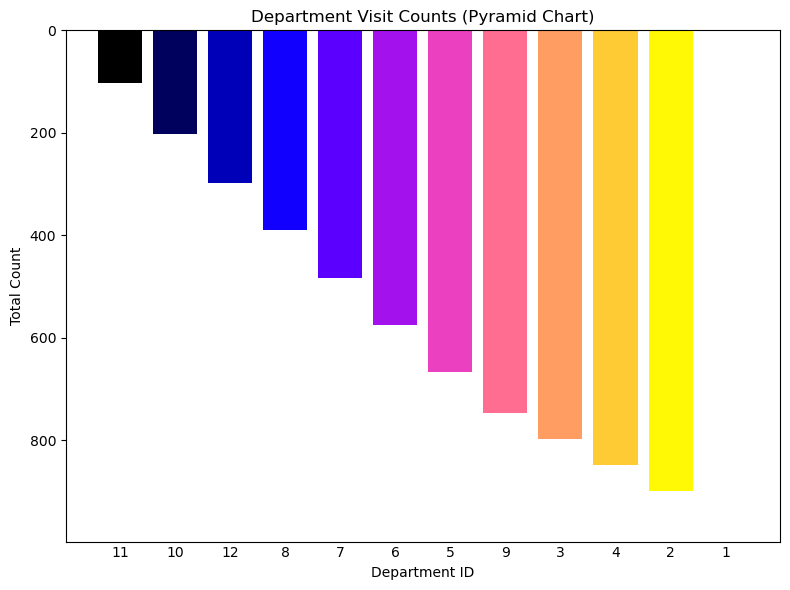

In [15]:
# Count the occurrences of each department ID
department_counts = collections.Counter(amb_visits['VisitDepartmentID'])

# Sort departments by counts
sorted_departments = sorted(department_counts.items(), key=lambda x: x[1], reverse=True)

# Extract sorted department IDs and their counts
departments, counts = zip(*sorted_departments)

# Create the pyramid chart
fig, ax = plt.subplots(figsize=(8, 6))

x = np.arange(len(departments))

heights = [sum(counts[:i+1]) for i in range(len(counts))]

cmap = plt.get_cmap('gnuplot2', len(departments))

for i in range(len(departments)):
    color = cmap(i)
    ax.bar(x[i], heights[i], color=color, align='center')

# Set labels and title
ax.set_xlabel('Department ID')
ax.set_ylabel('Total Count')
ax.set_title('Department Visit Counts (Pyramid Chart)')

ax.set_xticks(x)
ax.set_xticklabels(departments)
ax.invert_yaxis()
ax.xaxis.set_tick_params(size=0)

plt.tight_layout()
plt.show()



# 11. Create a sample pptx.

In [16]:
pip install python-pptx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Create a new presentation
prs = Presentation()

# Slide 1: Introduction
slide1 = prs.slides.add_slide(prs.slide_layouts[0])  # Use the first slide layout
title = slide1.shapes.title
subtitle = slide1.placeholders[1]

title.text = "PY-Coders"
subtitle.text = "Team Members:\n- Amitha Konduri\n- Amitha Sridhar\n- Lavanya Kannan\n- Shishira Srinivas"

# Slide 2: Content Slide
slide2 = prs.slides.add_slide(prs.slide_layouts[1])  
title = slide2.shapes.title
content = slide2.placeholders[1]

title.text = "Sample PPTX"
content.text = "This PPTX was created using Python"

# Slide 3: Thank You
slide3 = prs.slides.add_slide(prs.slide_layouts[5])  
title = slide3.shapes.title
content = slide3.placeholders[0]

title.text = "Thank you"
content.text = "Thank you! Have a nice day!"

# Save the presentation
prs.save("py-coders-sample.pptx")
print("Presentation saved.")


Presentation saved.


# 4:Machine Learning

In [18]:
#Merging
merged_pats_ed_visits = pd.merge(pats, ed_visits, on='PatientID', how='inner')

merged_pats_ed_ambulatory = pd.merge(merged_pats_ed_visits, amb_visits, left_on='PatientID', right_on='PatientMRN', how='inner')

final_merged_data = pd.merge(merged_pats_ed_ambulatory, re_adm, on='PatientID', how='inner')

In [19]:
final_merged_data

,PatientID,FirstName,LastName,DateOfBirth,Gender,Race,Language,Age,AgeBin,EDVisitID,...,DischargeDate,DischargeDisposition,Service,PrimaryDiagnosis,ExpectedLOS,ExpectedMortality,ReadmissionFlag,DaysToReadmission,EDVisitAfterDischargeFlag,expected_los
0,5,Tann,Bama,1962-05-01 19:12:58.950,Male,White,English,61,60-69,5,...,2018-01-05 05:47:04.933,Home,General Medicine,Flu,3.763352,0.307527,1.0,4.0,1.0,4.0
1,5,Tann,Bama,1962-05-01 19:12:58.950,Male,White,English,61,60-69,96,...,2018-01-05 05:47:04.933,Home,General Medicine,Flu,3.763352,0.307527,1.0,4.0,1.0,4.0
2,6,Jerrilyn,Kane,1969-03-30 09:36:56.550,Male,White,English,54,50-59,6,...,2018-01-05 14:18:30.029,Home,ICU,Heart Failure,13.650953,0.408898,NaN,NaN,NaN,14.0
3,6,Jerrilyn,Kane,1969-03-30 09:36:56.550,Male,White,English,54,50-59,97,...,2018-01-05 14:18:30.029,Home,ICU,Heart Failure,13.650953,0.408898,NaN,NaN,NaN,14.0
4,7,Skipton,Bar,1975-11-25 22:23:53.525,Male,White,English,48,40-49,7,...,2018-01-06 13:01:00.276,Home,Hospitalist,Pneumonia,9.555047,0.063634,1.0,4.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,665,Thor,Allder,1971-09-26 19:06:32.777,Male,Black/African-American,English,52,50-59,919,...,2018-03-01 19:56:09.361,Home,General Medicine,Diabetes,7.889449,0.302267,NaN,NaN,NaN,8.0
752,665,Thor,Allder,1971-09-26 19:06:32.777,Male,Black/African-American,English,52,50-59,919,...,2018-03-01 19:56:09.361,Home,General Medicine,Diabetes,7.889449,0.302267,NaN,NaN,NaN,8.0
753,668,Llewellyn,Buckmaster,1984-07-12 06:09:57.840,Male,Black/African-American,English,39,30-39,922,...,2018-03-02 20:22:26.558,Home,General Medicine,Diabetes,3.811283,0.285069,NaN,NaN,NaN,4.0
754,668,Llewellyn,Buckmaster,1984-07-12 06:09:57.840,Male,Black/African-American,English,39,30-39,922,...,2018-03-02 20:22:26.558,Home,General Medicine,Diabetes,3.811283,0.285069,NaN,NaN,NaN,4.0


In [20]:
final_data = final_merged_data[['DateOfBirth', 'Gender', 'Race', 'Acuity',
                         'BloodPressureSystolic', 'BloodPressureDiastolic',
                         'Pulse', 'ExpectedMortality']]
final_data

,DateOfBirth,Gender,Race,Acuity,BloodPressureSystolic,BloodPressureDiastolic,Pulse,ExpectedMortality
0,1962-05-01 19:12:58.950,Male,White,1,158.0,116.151006,59.360770,0.307527
1,1962-05-01 19:12:58.950,Male,White,2,158.0,116.151006,59.360770,0.307527
2,1969-03-30 09:36:56.550,Male,White,1,154.0,98.736556,67.425256,0.408898
3,1969-03-30 09:36:56.550,Male,White,1,154.0,98.736556,67.425256,0.408898
4,1975-11-25 22:23:53.525,Male,White,1,137.0,85.844944,97.442262,0.063634
...,...,...,...,...,...,...,...,...
751,1971-09-26 19:06:32.777,Male,Black/African-American,5,NaN,NaN,NaN,0.302267
752,1971-09-26 19:06:32.777,Male,Black/African-American,5,174.0,135.919219,66.544841,0.302267
753,1984-07-12 06:09:57.840,Male,Black/African-American,3,172.0,105.720900,78.228193,0.285069
754,1984-07-12 06:09:57.840,Male,Black/African-American,3,180.0,123.818634,72.088780,0.285069


In [21]:
current_year = datetime.now().year
final_data['Age'] = current_year - pd.to_datetime(final_data['DateOfBirth']).dt.year

final_data = final_data.drop(columns=['DateOfBirth'])

print(final_data.head())

  Gender   Race  Acuity  BloodPressureSystolic  BloodPressureDiastolic  \
0   Male  White       1                  158.0              116.151006   
1   Male  White       2                  158.0              116.151006   
2   Male  White       1                  154.0               98.736556   
3   Male  White       1                  154.0               98.736556   
4   Male  White       1                  137.0               85.844944   

       Pulse  ExpectedMortality  Age  
0  59.360770           0.307527   61  
1  59.360770           0.307527   61  
2  67.425256           0.408898   54  
3  67.425256           0.408898   54  
4  97.442262           0.063634   48  


C:\Users\Amitha\AppData\Local\Temp\ipykernel_36960\1521141452.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# Find and count null values in final_data
null_counts = final_data.isnull().sum()

# Display the count of null values for each column
print(null_counts)

Gender                      0
Race                        0
Acuity                      0
BloodPressureSystolic     116
BloodPressureDiastolic    116
Pulse                     116
ExpectedMortality           0
Age                         0
dtype: int64


In [23]:
final_data.dropna(inplace=True) 

In [24]:
# Find and count null values in final_data
null_counts = final_data.isnull().sum()

# Display the count of null values for each column
print(null_counts)

Gender                    0
Race                      0
Acuity                    0
BloodPressureSystolic     0
BloodPressureDiastolic    0
Pulse                     0
ExpectedMortality         0
Age                       0
dtype: int64


In [25]:
gender_mapping = {'Male': 1, 'Female': 0}
final_data['Gender'] = final_data['Gender'].map(gender_mapping)

In [26]:
race_mapping = {'White': 1, 'Black/African-American': 0}
final_data['Race'] = final_data['Race'].replace(race_mapping)

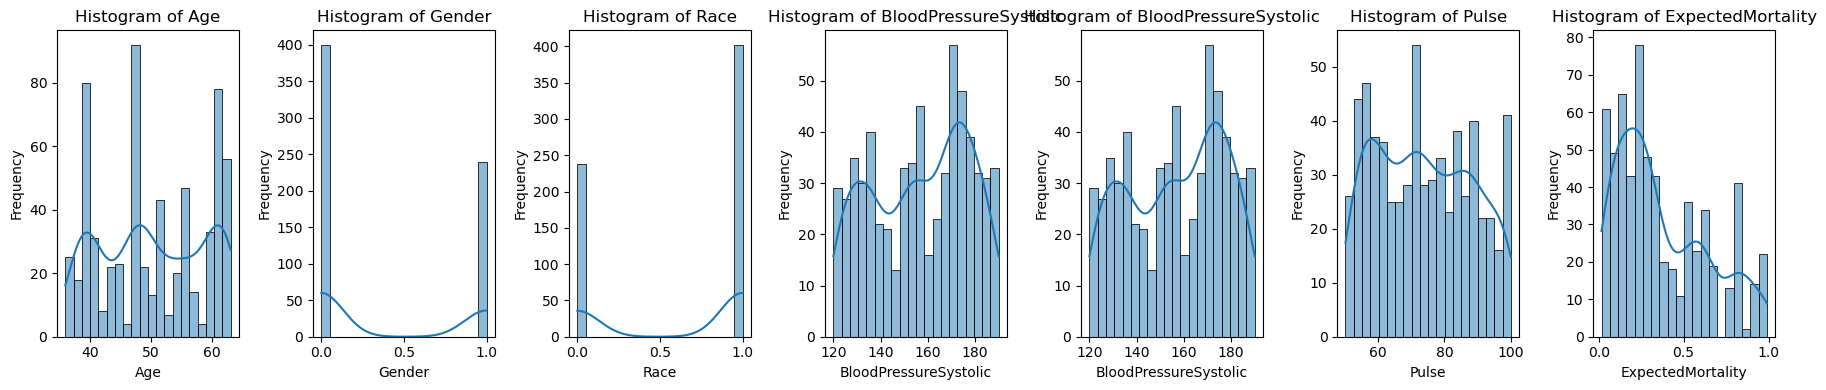

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming final_data is your DataFrame
numeric_columns = ['Age', 'Gender','Race','BloodPressureSystolic', 'BloodPressureSystolic', 'Pulse', 'ExpectedMortality']

# Create a histogram plot for numeric columns using subplots
fig, axes = plt.subplots(nrows=1, ncols=len(numeric_columns), figsize=(18, 4))

for i, column in enumerate(numeric_columns):
    sns.histplot(final_data[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
final_data.dropna(inplace=True)

# Define features (X) and target variable (y)
X = final_data.drop(columns=['ExpectedMortality'])
y = final_data['ExpectedMortality']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (512, 7)
Shape of X_test: (128, 7)
Shape of y_train: (512,)
Shape of y_test: (128,)


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a list of tuples containing model names and their corresponding instances
models = [
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('Support Vector Machine', SVR()),
    ('K-Nearest Neighbors', KNeighborsRegressor()),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
]

# Create an empty dictionary to store evaluation results
results = {}

# Loop through each model
for model_name, model in models:
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store results in the dictionary
    results[model_name] = {
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Error': mae,
        'R-squared': r2
    }

# Print the comparison matrix
print("Comparison Matrix:")
for model_name, metrics in results.items():
    print(model_name)
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()


Comparison Matrix:
Linear Regression
Mean Squared Error: 0.05980168517018238
Root Mean Squared Error: 0.24454383077514424
Mean Absolute Error: 0.20039370825832775
R-squared: 0.05563708410888635

Decision Tree
Mean Squared Error: 0.04944345643061715
Root Mean Squared Error: 0.22235884608132223
Mean Absolute Error: 0.11027509444972192
R-squared: 0.21920985079808175

Random Forest
Mean Squared Error: 0.03387628741425565
Root Mean Squared Error: 0.1840551205868928
Mean Absolute Error: 0.1336545067576197
R-squared: 0.4650399989389742

Gradient Boosting
Mean Squared Error: 0.04065660314570105
Root Mean Squared Error: 0.20163482622230974
Mean Absolute Error: 0.15515622590257838
R-squared: 0.3579681210046247

Support Vector Machine
Mean Squared Error: 0.058721945432507645
Root Mean Squared Error: 0.24232611380639035
Mean Absolute Error: 0.1983049789796742
R-squared: 0.07268787731266113

K-Nearest Neighbors
Mean Squared Error: 0.06472219690540529
Root Mean Squared Error: 0.25440557561776295
Mea

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)


Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.03384459724023785
Root Mean Squared Error: 0.1839690116303228
R-squared: 0.46554043676201184


In [31]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:

print("Best Hyperparameters:", best_params)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 0.03384459724023785
Root Mean Squared Error: 0.1839690116303228
R-squared: 0.46554043676201184


In [33]:
import joblib
model_filename = 'trained_random_forest_model.joblib'
joblib.dump(rf_model, model_filename)


['trained_random_forest_model.joblib']

In [34]:
# Load the trained model
loaded_model = joblib.load('trained_random_forest_model.joblib') 

In [35]:
print("Loaded Model Information:", loaded_model)

Loaded Model Information: RandomForestRegressor(random_state=42)


In [36]:
def get_user_input():
    age = int(input("Enter age: "))
    gender = int(input("Enter gender (Male: 1 / Female: 0): "))
    race = int(input("Enter race (White: 1 / Black(African/American): 2): "))
    sbp = float(input("Enter BloodPressureSystolic: "))
    dbp = float(input("Enter BloodPressureDiastolic: "))
    pulse = float(input("Enter Pulse: "))
    return {'Age': age, 'Gender': gender, 'Race': race, 
            'BloodPressureSystolic': sbp, 'BloodPressureDiastolic': dbp, 'Pulse': pulse}


In [37]:
def preprocess_user_input(user_input):
    # Apply the same preprocessing steps you used on your training data
    age = user_input['Age']
    gender = user_input['Gender']
    race = user_input['Race']
    sbp = user_input['BloodPressureSystolic']
    dbp = user_input['BloodPressureDiastolic']
    pulse = user_input['Pulse']
    
    # Print debug information
    print("Original Inputs:")
    print("Age:", age)
    print("Gender:", gender)
    print("Race:", race)
    print("Systolic BP:", sbp)
    print("Diastolic BP:", dbp)
    print("Pulse:", pulse)
    
    # Replace these with your actual min and max values used during scaling
    min_sbp, max_sbp = 80, 180
    min_dbp, max_dbp = 50, 120
    min_pulse, max_pulse = 60, 120
    
    # Apply scaling
    sbp_scaled = (sbp - min_sbp) / (max_sbp - min_sbp)
    dbp_scaled = (dbp - min_dbp) / (max_dbp - min_dbp)
    pulse_scaled = (pulse - min_pulse) / (max_pulse - min_pulse)
    
    preprocessed_input = {
        'Age': age, 'Gender': gender, 'Race': race,
        'BloodPressureSystolic': sbp_scaled,
        'BloodPressureDiastolic': dbp_scaled,
        'Pulse': pulse_scaled
    }
    
    # Print debug information
    print("Preprocessed Inputs:")
    print("Age:", preprocessed_input['Age'])
    print("Gender:", preprocessed_input['Gender'])
    print("Race:", preprocessed_input['Race'])
    print("Systolic BP Scaled:", preprocessed_input['BloodPressureSystolic'])
    print("Diastolic BP Scaled:", preprocessed_input['BloodPressureDiastolic'])
    print("Pulse Scaled:", preprocessed_input['Pulse'])
    
    return preprocessed_input


In [44]:
num_unique_patients = pats['PatientID'].nunique()

print("Number of unique patients:", num_unique_patients)

Number of unique patients: 945
